Epoch [1/10], Loss: 1.2848
Epoch [2/10], Loss: 0.8954
Epoch [3/10], Loss: 0.6968
Epoch [4/10], Loss: 0.5210
Epoch [5/10], Loss: 0.3609
Epoch [6/10], Loss: 0.2182
Epoch [7/10], Loss: 0.1334
Epoch [8/10], Loss: 0.0881
Epoch [9/10], Loss: 0.0716
Epoch [10/10], Loss: 0.0595
Test Accuracy: 72.42%


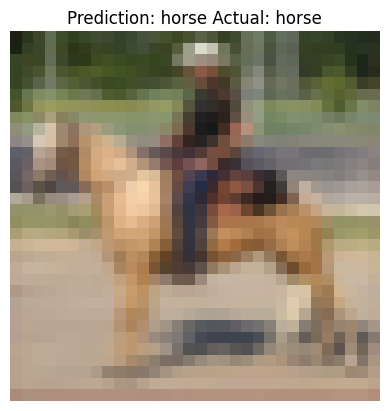

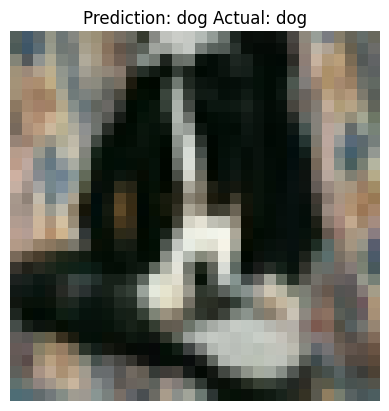

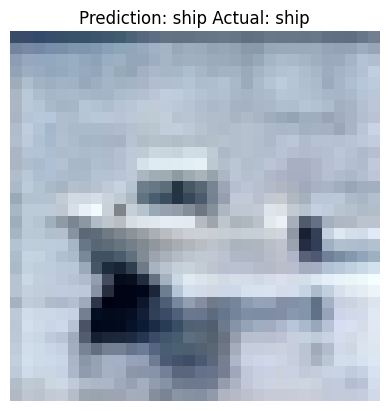

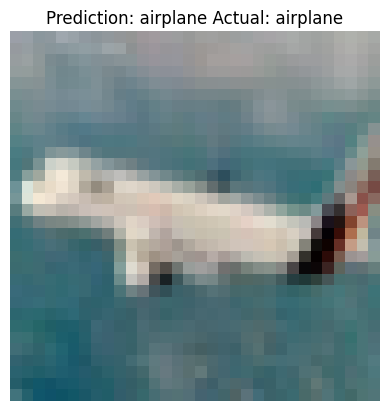

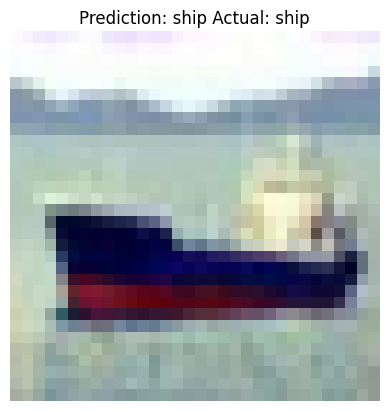

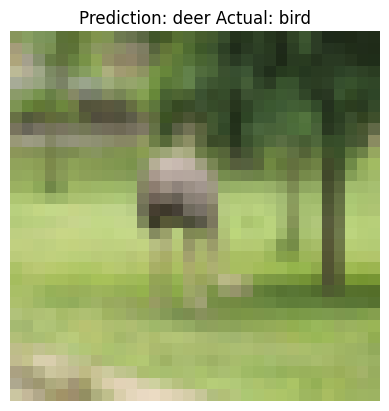

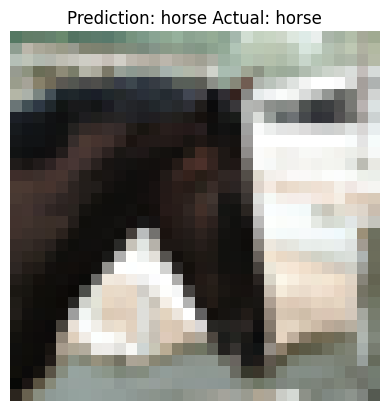

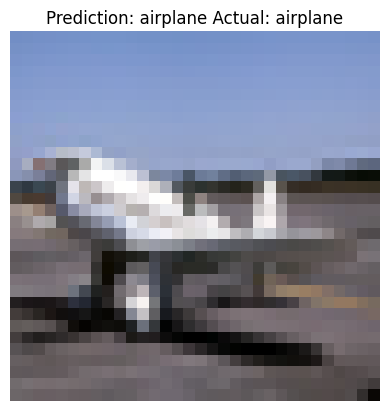

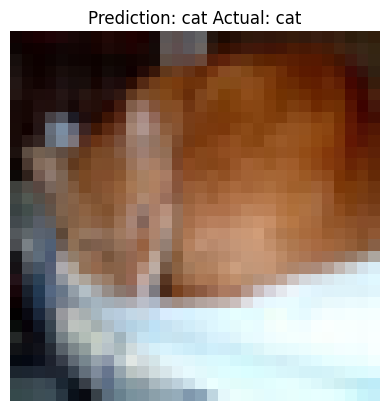

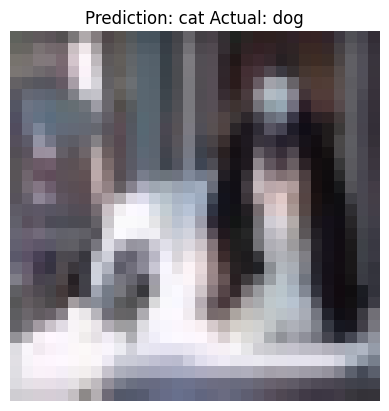

In [8]:
# Step 1: Import libraries
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn

# Step 2: Transforms, load datasets, and prepare data (batch, shuffle)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) #3 channels
])

training_dataset=datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_dataset=datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader=torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
testing_loader=torch.utils.data.DataLoader(testing_dataset, batch_size=64, shuffle=False)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Step 4: Define CNN Model
class CIFARNet(nn.Module):
  def __init__(self):
    super(CIFARNet, self).__init__()

    # Convolutional layers
    self.convolution_one = nn.Conv2d(3, 32, 3, padding=1)   # input: 3 channels (RGB)
    self.convolution_two = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)               # reduces image size by 2

    # Fully connected layers
    self.fully_connected_one = nn.Linear(64 * 8 * 8, 512)        # 32x32 -> 16x16 -> 8x8 after 2 pools
    self.fully_connected_two = nn.Linear(512, 10)                # 10 classes for CIFAR-10

  def forward(self, x):
      x = self.pool(F.relu(self.convolution_one(x)))    # convolution_one + ReLU + Pool
      x = self.pool(F.relu(self.convolution_two(x)))    # convolution_two + ReLU + Pool
      x = x.view(-1, 64 * 8 * 8)  # flattens
      x = F.relu(self.fully_connected_one(x))
      x = self.fully_connected_two(x)       # raw logits
      return x



# Step 5: Get images to display them
dataiter = iter(training_loader)
images, labels = next(dataiter)

def imshow(image, label=None, pred=None):
  image = image / 2 + 0.5  # unnormalizes data
  npimg = image.cpu().numpy().transpose((1, 2, 0)) # moves tensor from gpu to
            #cpu, numpy, change order of dimensions from channels, height, width
            #to height, width, channel because of plt
  plt.imshow(npimg)
  title = ''
  if label is not None:
    title += f"Label: {label}"
  if pred is not None:
    title += f"{pred}"
  plt.title(title)
  plt.axis('off')
  plt.show()



# Step 6: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFARNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for images, labels in training_loader: #each batch
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{10}], Loss: {running_loss/len(training_loader):.4f}")


# Step 7: Test
correct = 0
total = 0
model.eval()

sample_images, sample_labels, sample_predictions = None, None, None
with torch.no_grad():
  for images, labels in testing_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    if sample_images is None:
      sample_images = images
      sample_labels = labels
      sample_predictions = predicted

# Step 8: Print
print(f'Test Accuracy: {100* correct / total:.2f}%')
for i in range(10):
  label_name = classes[labels[i].item()]
  prediction_name = classes[predicted[i].item()]
  title = f"Prediction: {prediction_name}, Actual: {label_name}"
  imshow(images[i].cpu(), label=None, pred=title)





